In [ ]:
pip install tensorflow

In [ ]:
pip install sklearn

In [ ]:
pip install matplotlib

In [ ]:
pip install keras

In [ ]:
pip install seaborn

In [ ]:
pip install pydotplus

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob


from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('skinCancer/HAM10000_metadata_Incereased.csv')
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [3]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age             119
sex               0
localization      0
dtype: int64

In [4]:
df.count()

lesion_id       49517
image_id        49517
dx              49517
dx_type         49517
age             49398
sex             49517
localization    49517
dtype: int64

In [5]:
df['age'].fillna(int(df['age'].mean()),inplace=True)
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = 'skinCancer'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [7]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0027419...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0025030...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0026769...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0025661...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skinCancer\HAM10000_images_part_2\ISIC_0031633...,Benign keratosis-like lesions,2


In [8]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

<AxesSubplot:title={'center':'CELL TYPE'}, ylabel='Count'>

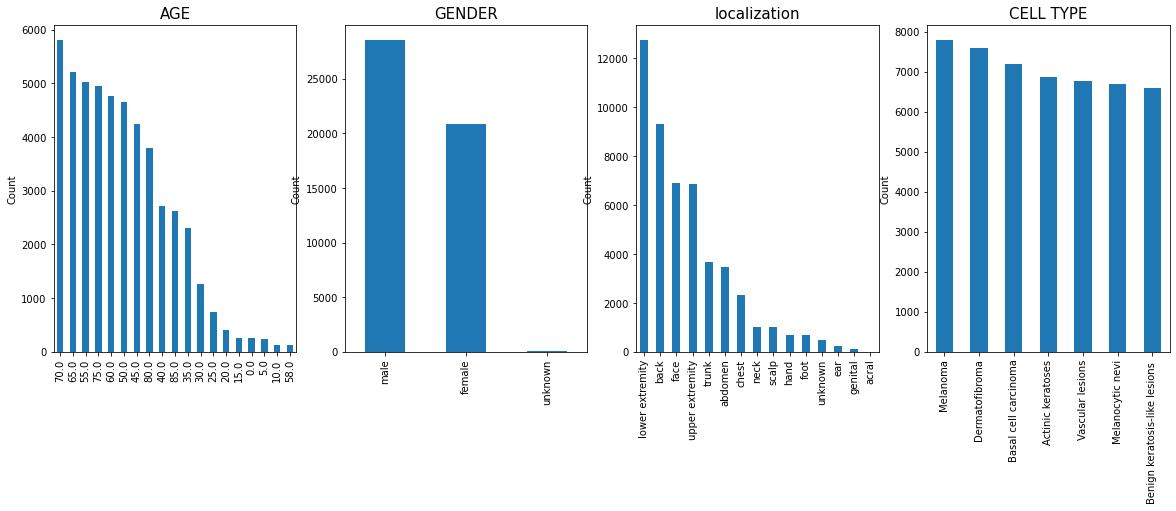

In [9]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
df['cell_type'].value_counts().plot.bar()

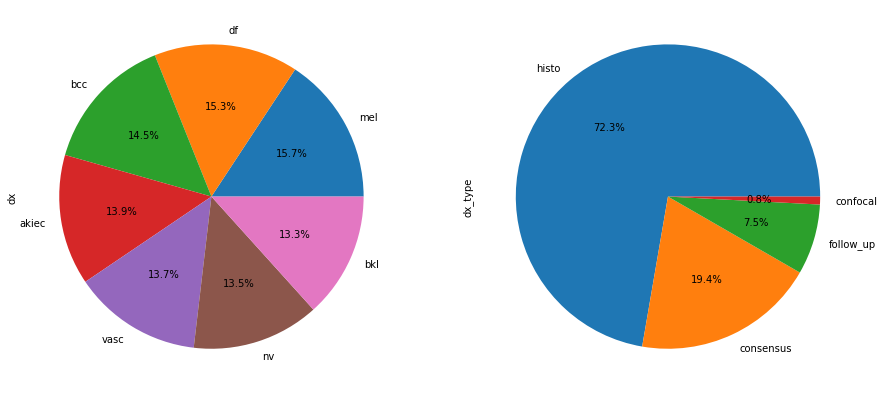

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

In [11]:
features=df.drop(columns=['cell_type_idx','image_id'],axis=1)
target=df['cell_type_idx']
features.head()

,lesion_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0027419...,Benign keratosis-like lesions,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0025030...,Benign keratosis-like lesions,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0026769...,Benign keratosis-like lesions,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,bkl,histo,80.0,male,scalp,skinCancer\HAM10000_images_part_1\ISIC_0025661...,Benign keratosis-like lesions,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,bkl,histo,75.0,male,ear,skinCancer\HAM10000_images_part_2\ISIC_0031633...,Benign keratosis-like lesions,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [12]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size = 0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Actinic keratoses', b'Basal cell carcinoma', b'Dermatofibroma',
       b'Melanoma', b'Benign keratosis-like lesions ',
       b'Melanocytic nevi', b'Vascular lesions'], dtype=object)>, idx=<tf.Tensor: shape=(37137,), dtype=int32, numpy=array([0, 1, 1, ..., 1, 1, 6])>)

In [13]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)


x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [14]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
y_test[1]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [16]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [17]:
y_test_o.value_counts()

5    1924
3    1907
1    1750
0    1730
6    1697
2    1689
4    1683
Name: cell_type_idx, dtype: int64

In [18]:
# x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 20)


# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train_o.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test_o.shape[0], *(100, 125, 3))


In [19]:
x_train = x_train.reshape(x_train.shape[0],125*100*3)
x_test = x_test.reshape(x_test.shape[0],125*100*3)
print(x_train.shape)
print(x_test.shape)

(37137, 37500)
(12380, 37500)


In [20]:
print(x_train)

[[ 0.67592044 -0.3525907   0.07794885 ...  0.96294681  0.12578657
   0.31713748]
 [-0.04164547 -0.85488684 -1.54853389 ...  0.1736243  -0.6874548
  -1.14191321]
 [ 0.07794885 -1.33326412 -1.45285844 ...  0.60416385 -0.23299638
  -0.16123979]
 ...
 [-2.93582799 -3.31852981 -2.79231481 ... -3.17501663 -3.41420527
  -3.03150345]
 [ 0.53240726 -0.63961707 -0.71137366 ...  0.19754317 -1.02231889
  -1.14191321]
 [ 0.93902794 -0.30475297  0.19754317 ...  0.65200158 -0.63961707
  -0.23299638]]


### Decision Tree

1
6
11
16
21
26
31
36
41
46


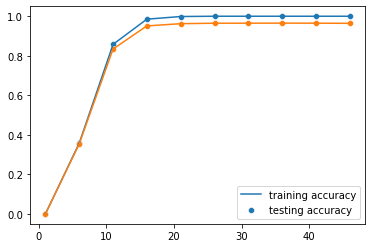

In [24]:
depth = range(1,51,5)
testing_accuracy = []
training_accuracy = []
score = 0

for i in depth:
    tree = DecisionTreeClassifier(max_depth = i, criterion = 'entropy')
    tree.fit(x_train, y_train)
    
    y_predict_train = tree.predict(x_train)
    training_accuracy.append(accuracy_score(y_train, y_predict_train))
    
    y_predict_test = tree.predict(x_test)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    print(i)

    if score < acc_score:
        score = acc_score
        best_depth = i
        
sns.lineplot(depth, training_accuracy)
sns.scatterplot(depth, training_accuracy)
sns.lineplot(depth, testing_accuracy)
sns.scatterplot(depth, testing_accuracy)
plt.legend(['training accuracy', 'testing accuracy'])

In [25]:
print('This is the best depth for Decision Tree Classifier: ', best_depth, '\nAccuracy score is: ', score)
result = confusion_matrix(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Confusion Matrix:","\n", result)
report = classification_report(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Classification Report:" , "\n", report)

This is the best depth for Decision Tree Classifier:  36 
Accuracy score is:  0.9651050080775444
Confusion Matrix: 
 [[1702    0    7    0   21    0    0]
 [   0 1736    0    0   11    0    3]
 [   0    0 1689    0    0    0    0]
 [   0    0    0 1907    0    0    0]
 [  22   41  126    7 1284  176   27]
 [   0    0    2    0    0 1922    0]
 [   0    0    0    0    0    0 1697]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1730
           1       0.98      0.99      0.98      1750
           2       0.93      1.00      0.96      1689
           3       1.00      1.00      1.00      1907
           4       0.98      0.76      0.86      1683
           5       0.92      1.00      0.96      1924
           6       0.98      1.00      0.99      1697

    accuracy                           0.96     12380
   macro avg       0.97      0.96      0.96     12380
weighted avg       0.97      0.96      0.96     1

### Random Forest

5
10
15
20
25
30
35
40
45
50


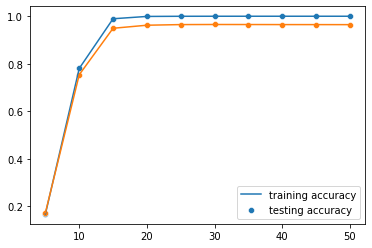

In [26]:
#random Forest
depth = range(5,51,5)
testing_accuracy = []
training_accuracy = []
score = 0

for i in depth:
    tree = RandomForestClassifier(max_depth = i, criterion = 'gini', random_state=6)
    tree.fit(x_train, y_train)
    
    y_predict_train = tree.predict(x_train)
    training_accuracy.append(accuracy_score(y_train, y_predict_train))
    
    y_predict_test = tree.predict(x_test)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    print(i)

    if score < acc_score:
        score = acc_score
        best_depth = i
        
sns.lineplot(depth, training_accuracy)
sns.scatterplot(depth, training_accuracy)
sns.lineplot(depth, testing_accuracy)
sns.scatterplot(depth, testing_accuracy)
plt.legend(['training accuracy', 'testing accuracy'])

In [27]:
print('This is the best depth for Decision Tree Classifier: ', best_depth, '\nAccuracy score is: ', score)
result = confusion_matrix(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Confusion Matrix:","\n", result)
report = classification_report(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Classification Report:" , "\n", report)

This is the best depth for Decision Tree Classifier:  30 
Accuracy score is:  0.9652665589660743
Confusion Matrix: 
 [[1730    0    0    0    0    0    0]
 [   0 1750    0    0    0    0    0]
 [   0    0 1689    0    0    0    0]
 [   0    0    0 1907    0    0    0]
 [ 398    3   15    0 1245   22    0]
 [   0    0    0    0    0 1924    0]
 [   0    0    0    0    0    0 1697]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      1730
           1       1.00      1.00      1.00      1750
           2       0.99      1.00      1.00      1689
           3       1.00      1.00      1.00      1907
           4       1.00      0.74      0.85      1683
           5       0.99      1.00      0.99      1924
           6       1.00      1.00      1.00      1697

    accuracy                           0.96     12380
   macro avg       0.97      0.96      0.96     12380
weighted avg       0.97      0.96      0.96     1

### KNN

In [ ]:
k = range(1,500,2)
testing_accuracy = []
training_accuracy = []
score = 0

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    
    y_predict_train = knn.predict(x_train)
    training_accuracy.append(accuracy_score(y_train, y_predict_train))
    
    y_predict_test = knn.predict(x_test)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    print(i)

    if score < acc_score:
        score = acc_score
        best_k = i
        
        
sns.lineplot(k, training_accuracy)
sns.scatterplot(k, training_accuracy)
sns.lineplot(k, testing_accuracy)
sns.scatterplot(k, testing_accuracy)
plt.legend(['training accuracy', 'testing accuracy'])

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167


In [ ]:
'''print('This is the best depth for Decision Tree Classifier: ', best_depth, '\nAccuracy score is: ', score)'''
result = confusion_matrix(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Confusion Matrix:","\n", result)
report = classification_report(y_test.argmax(axis=1), y_predict_test.argmax(axis=1),)
print("Classification Report:" , "\n", report)

In [41]:
x_train = x_train.reshape(x_train_o.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test_o.shape[0], *(100, 125, 3))
x_train.shape

(37137, 100, 125, 3)

### MLP

In [42]:
x_train = x_train.reshape(x_train.shape[0],125*100*3)
x_test = x_test.reshape(x_test.shape[0],125*100*3)

# define the keras model
model = Sequential()

model.add(Dense(units= 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
model.add(Dense(units= 256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               4800128   
                                                                 
 dense_17 (Dense)            (None, 256)               33024     
                                                                 
 dense_18 (Dense)            (None, 512)               131584    
                                                                 
 dense_19 (Dense)            (None, 64)                32832     
                                                                 
 dense_20 (Dense)            (None, 7)                 455       
                                                                 
Total params: 4,998,023
Trainable params: 4,998,023
Non-trainable params: 0
_________________________________________________________________


In [44]:
# compile the keras model
model.compile(optimizer = "Adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, batch_size = 500, epochs = 25)

Epoch 1/25
75/75 [==============================] - 10s 121ms/step - loss: 1.1428 - accuracy: 0.5539
Epoch 2/25
75/75 [==============================] - 8s 112ms/step - loss: 0.6291 - accuracy: 0.7566
Epoch 3/25
75/75 [==============================] - 8s 110ms/step - loss: 0.4084 - accuracy: 0.8398
Epoch 4/25
75/75 [==============================] - 8s 111ms/step - loss: 0.3396 - accuracy: 0.8653
Epoch 5/25
75/75 [==============================] - 8s 111ms/step - loss: 0.2478 - accuracy: 0.9056
Epoch 6/25
75/75 [==============================] - 8s 111ms/step - loss: 0.2107 - accuracy: 0.9229
Epoch 7/25
75/75 [==============================] - 8s 112ms/step - loss: 0.1843 - accuracy: 0.9320
Epoch 8/25
75/75 [==============================] - 8s 110ms/step - loss: 0.1260 - accuracy: 0.9542
Epoch 9/25
75/75 [==============================] - 8s 110ms/step - loss: 0.0978 - accuracy: 0.9651
Epoch 10/25
75/75 [==============================] - 8s 112ms/step - loss: 0.1328 - accuracy: 0.953

In [45]:
accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

387/387 [==============================] - 10s 25ms/step - loss: 0.1155 - accuracy: 0.9757
Test: accuracy =  97.56866097450256 %


### CNN

In [21]:
x_train = x_train.reshape(x_train.shape[0], 125,100,3)
x_test = x_test.reshape(x_test.shape[0], 125, 100, 3)
print(x_train.shape)
print(x_test.shape)

(37137, 125, 100, 3)
(12380, 125, 100, 3)


In [32]:
input_shape = (125, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 125, 100, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 100, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 62, 50, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 50, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 50, 128)       147584    
                                                      

In [33]:
model.compile(optimizer= "Adam",
            loss='categorical_crossentropy',
            metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [34]:
#x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)


# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(125, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(125, 100, 3))
#x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

tf.config.run_functions_eagerly(True)


model.fit(x_train, y_train, batch_size = 500, epochs = 10)

Epoch 1/10
75/75 [==============================] - 2494s 33s/step - loss: 1.9435 - accuracy: 0.3221
Epoch 2/10
75/75 [==============================] - 2491s 33s/step - loss: 1.1120 - accuracy: 0.5682
Epoch 3/10
75/75 [==============================] - 2481s 33s/step - loss: 0.6452 - accuracy: 0.7605
Epoch 4/10
75/75 [==============================] - 2484s 33s/step - loss: 0.3469 - accuracy: 0.8690
Epoch 5/10
75/75 [==============================] - 2483s 33s/step - loss: 0.2107 - accuracy: 0.9219
Epoch 6/10
75/75 [==============================] - 2463s 33s/step - loss: 0.1386 - accuracy: 0.9510
Epoch 7/10
75/75 [==============================] - 2462s 33s/step - loss: 0.0884 - accuracy: 0.9690
Epoch 8/10
75/75 [==============================] - 2460s 33s/step - loss: 0.0597 - accuracy: 0.9794
Epoch 9/10
75/75 [==============================] - 2467s 33s/step - loss: 0.0521 - accuracy: 0.9823
Epoch 10/10
75/75 [==============================] - 2452s 33s/step - loss: 0.0357 - accura

In [35]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy: ",test_acc*100,"%")

387/387 [==============================] - 207s 534ms/step - loss: 0.1155 - accuracy: 0.9727
Test Accuracy:  97.2697913646698 %
